# APTOS EDA 

Exploratory Data Analysis or EDA, is the simple process to do data analysis. In Machine learning context, we do EDA before start the model training to understand the data, process it and prepare for the actual model training.

In [1]:
# Necessary Packages
import matplotlib.pyplot as plt 
import random as python_random
import seaborn as sns 
import numpy as np 
import pandas as pd
import os, gc, random
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf; print(tf.__version__)


# for reproducibiity
def seed_all(s):
    random.seed(s)
    python_random.seed(s)
    tf.random.set_seed(s)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['PYTHONHASHSEED'] = str(0)
    
# seed all
SEED  = 1994
seed_all(SEED)

2.6.0


# Import Dataset

In [2]:
TRAIN_DF  = '../input/aptos2019-blindness-detection/train.csv'
TRAIN_IMG_PATH = '../input/aptos2019-blindness-detection/train_images/'

In [3]:
df = pd.read_csv(TRAIN_DF) 
df.head()

,id_code,diagnosis
0,000c1434d8d7,2
1,001639a390f0,4
2,0024cdab0c1e,1
3,002c21358ce6,0
4,005b95c28852,0


# Simple Visualization

In [4]:
intTostr = {
    0: 'No DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferative DR'
}
df['str_diagnosis'] = df['diagnosis'].map(intTostr)
df.head()

,id_code,diagnosis,str_diagnosis
0,000c1434d8d7,2,Moderate
1,001639a390f0,4,Proliferative DR
2,0024cdab0c1e,1,Mild
3,002c21358ce6,0,No DR
4,005b95c28852,0,No DR


Total Samples:  3662
Numerical counst of each category
0    1805
2     999
1     370
4     295
3     193
Name: diagnosis, dtype: int64


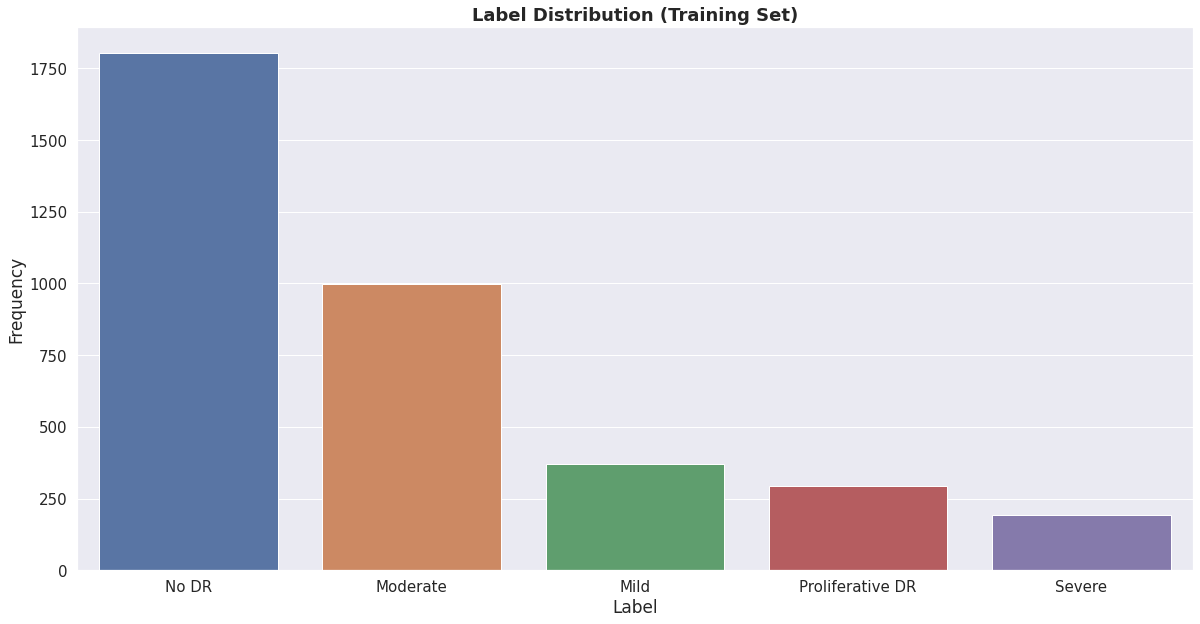

In [5]:
def display_data_distribution(df):
    # Label distribution
    plt.figure(figsize=(20, 10)) # control size of the figure 
    sns.set(style='darkgrid')    # fancy stype, to look good 

    # dispaly 
    sns.countplot(df['str_diagnosis'], order=df['str_diagnosis'].value_counts().index)
    plt.title("Label Distribution (Training Set)", weight='bold', fontsize=18)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel("Label", fontsize=17)
    plt.ylabel("Frequency", fontsize=17);
    plt.savefig('label_distribution.png', bbox_inches='tight')
    
    print('Total Samples: ', sum(df.diagnosis.value_counts()))
    print('Numerical counst of each category')
    print(df.diagnosis.value_counts()) # print how many samples each class 
    
# run full data frame (df)
display_data_distribution(df)

# Split: Train and Validation set and Test Set 

- সম্পুর্ন ডাটার ৭০% ব্যবহার হবে training এর জন্য, i.e. train set 
- ১০% ব্যবহার হবে validation এর জন্য, i.e validation set 
- ২০% ব্যবহার হবে testing এর জন্য, i.e. test set


`train set` সরাসরি মডেল ট্রেইনিং এর সময় ব্যবহার হবে; আর `validation set` ব্যবহার হবে hyper-parameter tuning এর জন্য। এবং সর্বশেষে test set ব্যবহার হবে ফাইনাল টেস্টিং এর সময়। 

In [6]:
from sklearn.model_selection import train_test_split 

# for way one - data generator
train_labels, val_test_labels = train_test_split(df,  
                                                 test_size = 0.30,  # 30%
                                                 random_state = SEED,
                                                 stratify = df['diagnosis'])

val_labels, test_labels = train_test_split(val_test_labels,  
                                           test_size = 0.20, # 20%
                                           random_state = SEED,
                                           stratify = val_test_labels['diagnosis'])

print(train_labels.shape, val_labels.shape, test_labels.shape) 

(2563, 3) (879, 3) (220, 3)


# Image Data Augmentation

We will use https://albumentations.ai/ library. What is Data augmentaiton and why we use it?

> Data augmentation in data analysis are techniques used to increase the amount of data by adding slightly modified copies of already existing data or newly created synthetic data from existing data. It acts as a regularizer and helps reduce overfitting when training a machine learning model.

source. (wiki)

In [7]:
import albumentations as A 

# For Training 
def albu_transforms_train(data_resize): 
    return A.Compose([
        A.Resize(data_resize, data_resize),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.ShiftScaleRotate(p=0.5),
        A.RandomRotate90(p=0.5),
        A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, 
                             val_shift_limit=0.2, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), 
                                   contrast_limit=(-0.1, 0.1), p=0.5),
        A.CoarseDropout(p=0.5),            
    ],  p=1.)

# For Validation 
def albu_transforms_valid(data_resize): 
    return A.Compose([
        A.Resize(data_resize, data_resize)
    ], p=1.)

# Data Generator

What is Data generator in keras and why we should care about it? [Answer](https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly). 

In [8]:
import tensorflow as tf 
import cv2

class APTOSGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_path, data, batch_size, random_state, 
                 dim, shuffle=True, transform=None):
        self.dim  = dim
        self.data = data
        self.random_state = random_state
        self.shuffle  = shuffle
        self.img_path = img_path
        self.augment  = transform
        self.batch_size = batch_size
        self.list_idx = data.index.values
        self.label = pd.get_dummies(data['diagnosis'],  columns = ['diagnosis'])
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.list_idx) / self.batch_size))
    
    def __getitem__(self, index):
        batch_idx = self.indices[index*self.batch_size:(index+1)*self.batch_size]
        idx = [self.list_idx[k] for k in batch_idx]
        
        Data   = np.empty((self.batch_size, *self.dim))
        Target = np.empty((self.batch_size, 5), dtype = np.float32)

        for i, k in enumerate(idx):
            # raw image 
            image = cv2.imread(self.img_path + self.data['id_code'][k] + '.png')[:, :, [2, 1, 0]]  
            
            # image augmentation 
            res = self.augment(image=image)
            image = res['image']
            
            Data[i,] =  image
            Target[i,] = self.label.loc[k,].values

        return Data, Target 
    
    def on_epoch_end(self):
        self.indices = np.arange(len(self.list_idx))
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(self.indices)

# Visualize Data Generator : Train Set

In [9]:
IMG_SIZE = 224 
BATCH_SIZE = 24

In [10]:
trian_gens = APTOSGenerator(TRAIN_IMG_PATH, 
                            train_labels, 
                            batch_size = BATCH_SIZE, 
                            random_state = SEED, 
                            dim = (IMG_SIZE, IMG_SIZE, 3),
                            shuffle = True,
                            transform = albu_transforms_train(IMG_SIZE))


User settings:

   KMP_AFFINITY=granularity=fine,verbose,compact,1,0
   KMP_BLOCKTIME=0
   KMP_DUPLICATE_LIB_OK=True
   KMP_INIT_AT_FORK=FALSE
   KMP_SETTINGS=1
   KMP_WARNINGS=0

Effective settings:

   KMP_ABORT_DELAY=0
   KMP_ADAPTIVE_LOCK_PROPS='1,1024'
   KMP_ALIGN_ALLOC=64
   KMP_ALL_THREADPRIVATE=128
   KMP_ATOMIC_MODE=2
   KMP_BLOCKTIME=0
   KMP_CPUINFO_FILE: value is not defined
   KMP_DETERMINISTIC_REDUCTION=false
   KMP_DEVICE_THREAD_LIMIT=2147483647
   KMP_DISP_NUM_BUFFERS=7
   KMP_DUPLICATE_LIB_OK=true
   KMP_ENABLE_TASK_THROTTLING=true
   KMP_FORCE_REDUCTION: value is not defined
   KMP_FOREIGN_THREADS_THREADPRIVATE=true
   KMP_FORKJOIN_BARRIER='2,2'
   KMP_FORKJOIN_BARRIER_PATTERN='hyper,hyper'
   KMP_GTID_MODE=3
   KMP_HANDLE_SIGNALS=false
   KMP_HOT_TEAMS_MAX_LEVEL=1
   KMP_HOT_TEAMS_MODE=0
   KMP_INIT_AT_FORK=true
   KMP_LIBRARY=throughput
   KMP_LOCK_KIND=queuing
   KMP_MALLOC_POOL_INCR=1M
   KMP_NUM_LOCKS_IN_BLOCK=1
   KMP_PLAIN_BARRIER='2,2'
   KMP_PLAIN_BARRIER_P

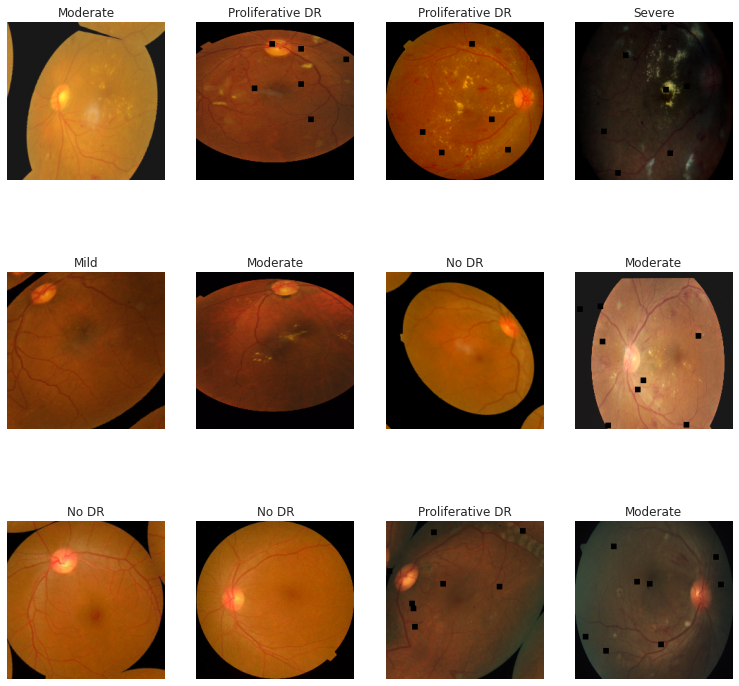

Total Samples:  2563
Numerical counst of each category
0    1263
2     699
1     259
4     207
3     135
Name: diagnosis, dtype: int64


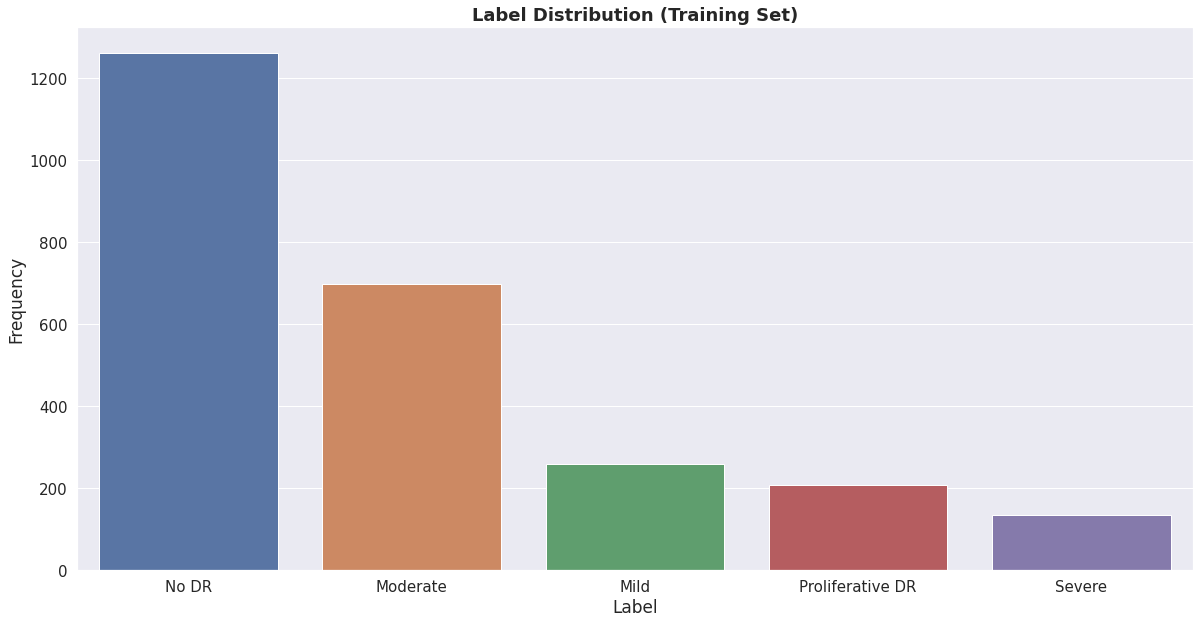

In [11]:
import matplotlib.pyplot as plt 

for i, (X,y) in enumerate(trian_gens):
    row=3; col=4; 
    plt.figure(figsize=(13, 13))
    for x in range(row*col):
        plt.subplot(row, col, x+1)
        plt.imshow(X[x,:,:,:] / 255.)
        plt.title(intTostr[tf.argmax(y[x], axis=-1).numpy()])
        plt.axis('off')
        plt.savefig('train_labels.png', bbox_inches='tight')
    plt.show()    
    break
    
# display data distro on specific training data frame
display_data_distribution(train_labels)

# Visualize Data Generator : Validation Set

In [12]:
val_gens = APTOSGenerator(TRAIN_IMG_PATH, 
                          val_labels,
                          batch_size = BATCH_SIZE, 
                          random_state = SEED, 
                          dim = (IMG_SIZE, IMG_SIZE, 3),
                          shuffle = False,
                          transform = albu_transforms_valid(IMG_SIZE))

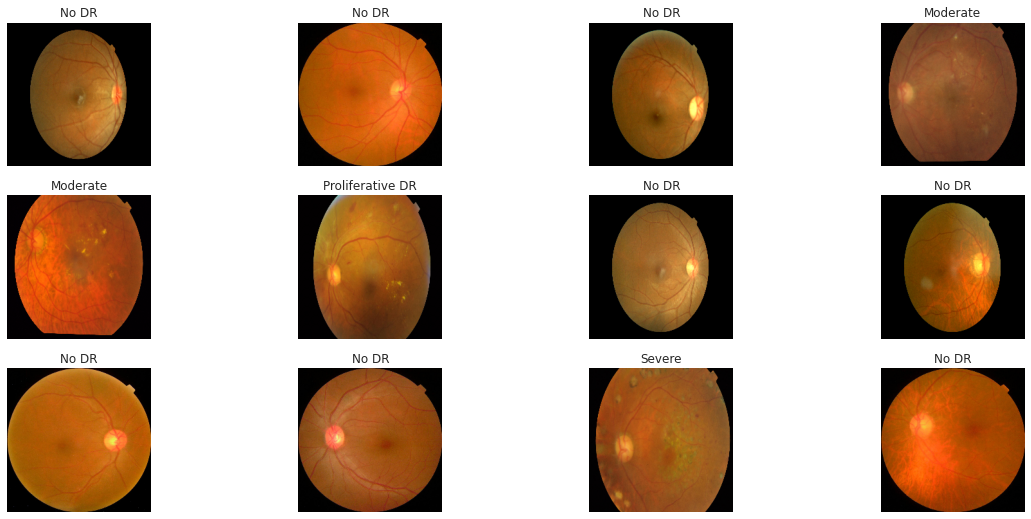

Total Samples:  879
Numerical counst of each category
0    434
2    240
1     89
4     70
3     46
Name: diagnosis, dtype: int64


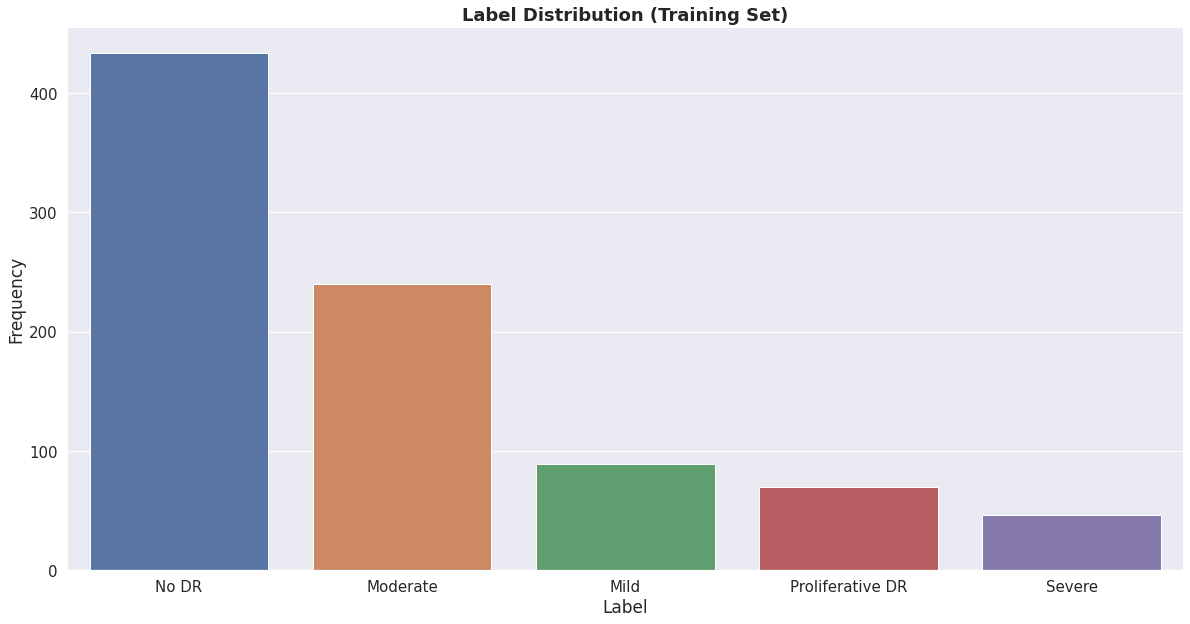

In [13]:
import matplotlib.pyplot as plt 

for i, (X,y) in enumerate(val_gens):
    row=3; col=4; 
    plt.figure(figsize=(20,(row/col)*12))
    
    for x in range(row*col):
        plt.subplot(row,col,x+1)
        plt.imshow(X[x,:,:,:] / 255.)
        plt.title(intTostr[tf.argmax(y[x], axis=-1).numpy()])
        plt.axis('off')
        plt.savefig('val_labels.png', bbox_inches='tight')
    plt.show()    
    break

# display data distro on specific validation data frame
display_data_distribution(val_labels)

# Visualize Data Generator : Test Set

In [14]:
test_gens = APTOSGenerator(TRAIN_IMG_PATH, 
                          test_labels,
                          batch_size = BATCH_SIZE, 
                          random_state = SEED, 
                          dim = (IMG_SIZE, IMG_SIZE, 3),
                          shuffle = False,
                          transform = albu_transforms_valid(IMG_SIZE))

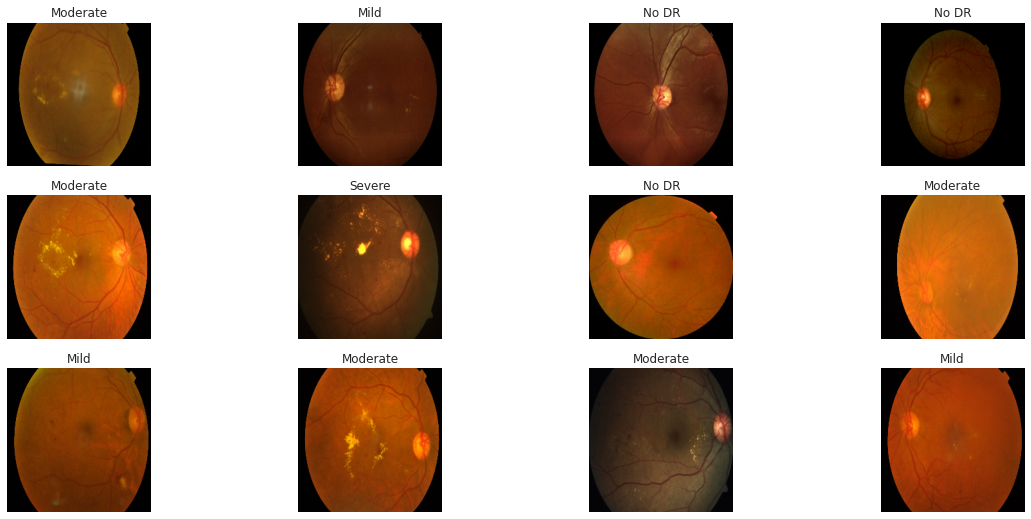

Total Samples:  220
Numerical counst of each category
0    108
2     60
1     22
4     18
3     12
Name: diagnosis, dtype: int64


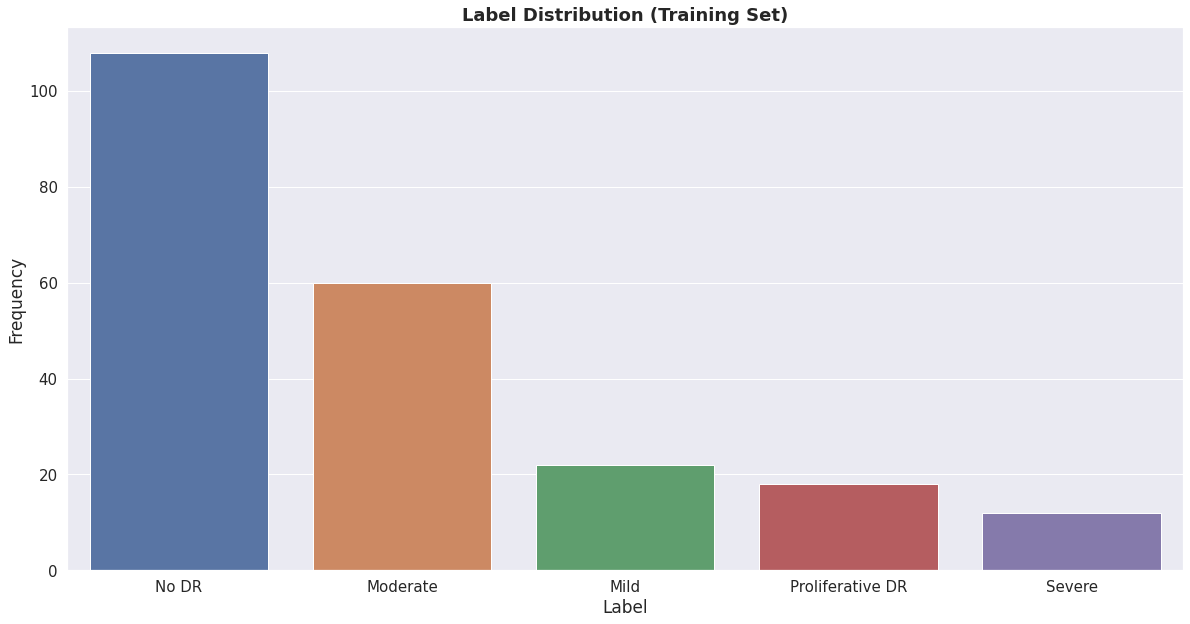

In [15]:
import matplotlib.pyplot as plt 

for i, (X,y) in enumerate(test_gens):
    row=3; col=4; 
    plt.figure(figsize=(20,(row/col)*12))
    
    for x in range(row*col):
        plt.subplot(row,col,x+1)
        plt.imshow(X[x,:,:,:] / 255.)
        plt.title(intTostr[tf.argmax(y[x], axis=-1).numpy()])
        plt.axis('off')
        plt.savefig('test_labels.png', bbox_inches='tight')
    plt.show()    
    break

# display data distro on specific validation data frame
display_data_distribution(test_labels)

# Note

**Machine Learning** is a method of data analysis that automates analytical model building. Using algorithms that learn from data in iterative fashion. Machine Learning allows computer to find hidden insight without being explicitly programmed where to look. System are often called Model which can learn to perform a specific task by analyzing lots of examples for particular problems.

**Machine Learning Process**. At first we need to acquire data. There’re many technique to access this data. However after acquiring data we need to clean it properly. Because real world data is really messy.

- Inconsistent values
- Duplicate values
- Missing values
- Invalid values
- Outliers

So we should address data quality issue -

- Remove data with missing values
- Merge duplicate records
- Generates best estimate for invalid issues
- Remove outliers

Data preparation is very important for our models. Models are learned from the data and perform , so the amount and quality of data available for building the models are important factors. After cleaning the data sets we then need to split it into three part **Train** set, **Validation** set and **Test** set. We’ll build and train our models using **Train** data sets and use **Validation** data for fine-tuning the hyper-parameter and lastly we’ll test our models using **Test** data sets. Now this’s an iterative process as because we need to get best models. After the model is ready , then we can deploy our model.


![](https://qph.fs.quoracdn.net/main-qimg-bba6333a2ddde361835c87351d178c63)


**What is Hyper-parameter Tuning?**. There are some parameter which can make huge impact on model performance, either good or bad. Such parameter are: image size, learning rate, epochs, batch size etc. These are called hyper-parameter. Now, the **Validation** set can be used to find the best value of them. For example: let's say we train a model with image size `100` and the model performance on validatin set achievs 50% and later we increase the image size `512` and for that the performance on validation set increases to 70%. And from this test, we can pick image size `512`, as it gives higher score. It's one of the hyper-paramer (image size) and the process refer to hyper-parameter tuning.

---

Final Note:

- It's a simple EDA note.
- Next, we will train the Deep network.